In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray import train, tune
from ray.tune import ResultGrid

/Users/zkarwowska/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [4]:
%reload_ext tensorboard
%tensorboard --logdir runs


In [2]:
%cd ..

/Users/zkarwowska/TomaszLab Dropbox/Zuzanna Karwowsk/My Mac (zkarwowska’s MacBook Pro)/Desktop/microbiome_gpt


In [3]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [4]:
taxonomy = pd.read_csv('inputs/taxonomy.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
metadata = pd.read_csv('inputs/metadata.csv', index_col= [0], low_memory=False).sort_index()

metadata['SICK'] = np.where(metadata.disease == 'healthy', 0, 1)

In [5]:
pathways_val1 = pd.read_csv('inputs/HMP_2019_ibdmdb_pathways.csv', index_col= [0], low_memory=False).iloc[:, 2:].sort_index()
pathways_val2 = pd.read_csv('inputs/HMP_2019_ibdmdb_pathways_healthy.csv', index_col= [0], low_memory=False).iloc[:, 2:].sort_index()
pathways = pd.concat([pathways_val1, pathways_val2], axis=0)


metadata_val = metadata[metadata['sample_id'].isin(pathways.index)]
val_samples = metadata_val.drop_duplicates(subset = 'subject_id').sample_id

taxonomy_val = taxonomy[taxonomy.index.isin(val_samples)]

In [6]:
data = pd.concat([metadata_val.set_index('sample_id')[['age', 'BMI', 'SICK']], taxonomy_val.iloc[:, :8]], axis=1).dropna()

y_age = data.age.values
y_bmi = data.BMI.values
y_health = data.SICK.values

X = data.iloc[:, 3:].values

X_train, X_test, y_age_train, y_age_test, y_bmi_train, y_bmi_test, y_health_train, y_health_test = train_test_split(
    X, y_age, y_bmi, y_health, test_size=0.3, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_age_train = torch.tensor(y_age_train, dtype=torch.float32).view(-1, 1)
y_age_test = torch.tensor(y_age_test, dtype=torch.float32).view(-1, 1)
y_bmi_train = torch.tensor(y_bmi_train, dtype=torch.float32).view(-1, 1)
y_bmi_test = torch.tensor(y_bmi_test, dtype=torch.float32).view(-1, 1)
y_health_train = torch.tensor(y_health_train, dtype=torch.float32).view(-1, 1)
y_health_test = torch.tensor(y_health_test, dtype=torch.float32).view(-1, 1)

In [7]:
# Define a neural network model with multiple outputs
class MultiOutputNN(nn.Module):
    def __init__(self, input_dim, hidden_units=32, activation=nn.ReLU):
        super(MultiOutputNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        
        # Output layers for each task
        self.fc_age = nn.Linear(hidden_units, 1)  # For predicting age (continuous)
        self.fc_bmi = nn.Linear(hidden_units, 1)  # For predicting BMI (continuous)
        self.fc_health = nn.Linear(hidden_units, 1)  # For predicting health (binary)

        self.activation = activation()
        self.sigmoid = nn.Sigmoid()  # For binary output

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        
        age_out = self.fc_age(x)
        bmi_out = self.fc_bmi(x)
        health_out = self.sigmoid(self.fc_health(x))  # Apply sigmoid to binary output

        return age_out, bmi_out, health_out

In [48]:
def tune_model(config):
            
    model = MultiOutputNN(input_dim=X_train.shape[1], hidden_units=config['hidden_units'])
    
    # Define the loss functions for each output
    criterion_age = nn.HuberLoss()
    criterion_bmi = nn.HuberLoss()
    criterion_health = nn.BCELoss()  

    # Define a single optimizer for all parameters
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    
    n_epochs = config['epochs']
    batch_size = config['batch_size']

    # Convert data to DataLoader
    train_data = torch.utils.data.TensorDataset(X_train, y_age_train, y_bmi_train, y_health_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    test_data = torch.utils.data.TensorDataset(X_test, y_age_test, y_bmi_test, y_health_test)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


    for epoch in range(n_epochs):

        model.train()
        running_loss_age = 0.0
        running_loss_bmi = 0.0
        running_loss_health = 0.0
        running_total_loss = 0.0
        train_steps = 0.0

        for batch_X, batch_y_age, batch_y_bmi, batch_y_health in train_loader:

            batch_X = batch_X.to(DEVICE)
            optimizer.zero_grad()

            age_out, bmi_out, health_out = model(batch_X)

            loss_age = criterion_age(age_out, batch_y_age)
            loss_bmi = criterion_bmi(bmi_out, batch_y_bmi)
            loss_health = criterion_health(health_out, batch_y_health)

            # Dynamically scale the losses
            scale_age = 1.0 / (loss_age.item() + 1e-8)  # Add a small value to prevent division by zero
            scale_bmi = 1.0 / (loss_bmi.item() + 1e-8)
            scale_health = 1.0 / (loss_health.item() + 1e-8)

            # Combine losses with dynamic scaling
            loss = (scale_age * loss_age + scale_bmi * loss_bmi + scale_health * loss_health) / (scale_age + scale_bmi + scale_health)

            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss_age += loss_age.item()
            running_loss_bmi += loss_bmi.item()
            running_loss_health += loss_health.item()
            running_total_loss += loss.item()
            
            train_steps += 1

        model.train()
        test_loss_age = 0.0
        test_loss_bmi = 0.0
        test_loss_health = 0.0
        test_total_loss = 0.0
        test_steps = 0.0    
        with torch.no_grad():
            for batch_X, batch_y_age, batch_y_bmi, batch_y_health in test_loader:

                batch_X = batch_X.to(DEVICE)
                age_out, bmi_out, health_out = model(batch_X)

                loss_age = criterion_age(age_out, batch_y_age)
                loss_bmi = criterion_bmi(bmi_out, batch_y_bmi)
                loss_health = criterion_health(health_out, batch_y_health)
                
                # Dynamically scale the losses
                scale_age = 1.0 / (loss_age.item() + 1e-8)  # Add a small value to prevent division by zero
                scale_bmi = 1.0 / (loss_bmi.item() + 1e-8)
                scale_health = 1.0 / (loss_health.item() + 1e-8)

                # Combine losses with dynamic scaling
                loss = (scale_age * loss_age + scale_bmi * loss_bmi + scale_health * loss_health) / (scale_age + scale_bmi + scale_health)

                test_loss_age += loss_age.item()
                test_loss_bmi += loss_bmi.item()
                test_loss_health += loss_health.item()
                test_total_loss += loss.item()
                test_steps += 1

        avg_train_age_loss = running_loss_age / train_steps
        avg_train_bmi_loss = running_loss_bmi / train_steps
        avg_train_health_loss = running_loss_health / train_steps
        avg_train_total_loss = running_total_loss / train_steps

        avg_test_age_loss = test_loss_age / test_steps
        avg_test_bmi_loss = test_loss_bmi / test_steps
        avg_test_health_loss = test_loss_health / test_steps
        avg_test_total_loss = test_total_loss / test_steps

        
        tune.report(train_age_loss=avg_train_age_loss, 
                    train_bmi_loss=avg_train_bmi_loss,
                    train_health_loss = avg_train_health_loss,
                    train_total_loss=running_total_loss,
                    test_age_loss = avg_test_age_loss,
                    test_bmi_loss = avg_test_bmi_loss,
                    test_health_loss = avg_test_health_loss,
                    test_total_loss = avg_test_total_loss)

In [60]:
# Hyperparameter space to search over
config = {
    "batch_size": tune.choice([8, 16, 32, 64]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "epochs":tune.choice([50]),
    "hidden_units":tune.choice([128, 64, 32, 16, 8])
}

# Running the Ray Tune experiment with metric and mode
analysis = tune.run(
    tune_model,
    config=config,
    num_samples=20,  # Number of samples to try
    resources_per_trial={"cpu": 2, "gpu": 0},  # Adjust based on your environment
    local_dir="ray_results",  # Directory where results will be saved
    metric="test_total_loss",  # Metric to optimize
    mode="min",  # Minimize the test loss
    verbose=0
)

In [61]:
# Get the best configuration found during tuning
best_config = analysis.get_best_config(metric="train_total_loss", mode="min")
print("Best Config: ", best_config)

# Get the best trial corresponding to the best config
best_trial = analysis.get_best_trial(metric="train_total_loss", mode="min")

# Retrieve the final losses from the best trial
best_age_loss = best_trial.last_result["test_age_loss"]
best_bmi_loss = best_trial.last_result["test_bmi_loss"]
best_health_loss = best_trial.last_result["test_health_loss"]

print(f"Best age loss: {best_age_loss}")
print(f"Best bmi loss: {best_bmi_loss}")
print(f"Best health loss: {best_health_loss}")

Best Config:  {'batch_size': 64, 'lr': 0.02716362205850574, 'epochs': 50, 'hidden_units': 16}
Best age loss: 179.50927734375
Best bmi loss: 752.7068481445312
Best health loss: 4.454413890838623


In [62]:
def run_model(config=best_config):
            
    model = MultiOutputNN(input_dim=X_train.shape[1], hidden_units=config['hidden_units'])
    
    # Define the loss functions for each output
    criterion_age = nn.HuberLoss()
    criterion_bmi = nn.HuberLoss()
    criterion_health = nn.BCELoss()  

    # Define a single optimizer for all parameters
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    
    n_epochs = config['epochs']
    batch_size = config['batch_size']

    # Convert data to DataLoader
    train_data = torch.utils.data.TensorDataset(X_train, y_age_train, y_bmi_train, y_health_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    test_data = torch.utils.data.TensorDataset(X_test, y_age_test, y_bmi_test, y_health_test)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

    results = []
    for epoch in range(n_epochs):

        model.train()
        running_loss_age = 0.0
        running_loss_bmi = 0.0
        running_loss_health = 0.0
        running_total_loss = 0.0
        train_steps = 0.0

        for batch_X, batch_y_age, batch_y_bmi, batch_y_health in train_loader:

            batch_X = batch_X.to(DEVICE)
            optimizer.zero_grad()

            age_out, bmi_out, health_out = model(batch_X)

            loss_age = criterion_age(age_out, batch_y_age)
            loss_bmi = criterion_bmi(bmi_out, batch_y_bmi)
            loss_health = criterion_health(health_out, batch_y_health)

            # Dynamically scale the losses
            scale_age = 1.0 / (loss_age.item() + 1e-8)  # Add a small value to prevent division by zero
            scale_bmi = 1.0 / (loss_bmi.item() + 1e-8)
            scale_health = 1.0 / (loss_health.item() + 1e-8)

            # Combine losses with dynamic scaling
            loss = (scale_age * loss_age + scale_bmi * loss_bmi + scale_health * loss_health) / (scale_age + scale_bmi + scale_health)

            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss_age += loss_age.item()
            running_loss_bmi += loss_bmi.item()
            running_loss_health += loss_health.item()
            running_total_loss += loss.item()
            
            train_steps += 1

        model.train()
        test_loss_age = 0.0
        test_loss_bmi = 0.0
        test_loss_health = 0.0
        test_total_loss = 0.0 
        test_steps = 0.0    
        with torch.no_grad():
            for batch_X, batch_y_age, batch_y_bmi, batch_y_health in test_loader:

                batch_X = batch_X.to(DEVICE)
                age_out, bmi_out, health_out = model(batch_X)

                loss_age = criterion_age(age_out, batch_y_age)
                loss_bmi = criterion_bmi(bmi_out, batch_y_bmi)
                loss_health = criterion_health(health_out, batch_y_health)
                
                # Dynamically scale the losses
                scale_age = 1.0 / (loss_age.item() + 1e-8)  # Add a small value to prevent division by zero
                scale_bmi = 1.0 / (loss_bmi.item() + 1e-8)
                scale_health = 1.0 / (loss_health.item() + 1e-8)

                # Combine losses with dynamic scaling
                loss = (scale_age * loss_age + scale_bmi * loss_bmi + scale_health * loss_health) / (scale_age + scale_bmi + scale_health)


                test_loss_age += loss_age.item()
                test_loss_bmi += loss_bmi.item()
                test_loss_health += loss_health.item()
                test_total_loss += loss.item()

                test_steps += 1

        avg_train_age_loss = running_loss_age / train_steps
        avg_train_bmi_loss = running_loss_bmi / train_steps
        avg_train_health_loss = running_loss_health / train_steps
        avg_train_total_loss = running_total_loss / train_steps

        avg_test_age_loss = test_loss_age / test_steps
        avg_test_bmi_loss = test_loss_bmi / test_steps
        avg_test_health_loss = test_loss_health / test_steps
        avg_test_total_loss = test_total_loss / test_steps

        
        results.append({'epoch':epoch,
                        'train_age_loss' : avg_train_age_loss, 
                        'train_bmi_loss' : avg_train_bmi_loss,
                        'train_health_loss' : avg_train_health_loss,
                        'train_total_loss' : avg_train_total_loss,
                        'test_age_loss' : avg_test_age_loss,
                        'test_bmi_loss' : avg_test_bmi_loss,
                        'test_health_loss' : avg_test_health_loss,
                        'test_total_loss' : avg_test_total_loss
                       })
        
    return pd.DataFrame(results)

In [63]:
history = run_model()

In [66]:
history.head()

,epoch,train_age_loss,train_bmi_loss,train_health_loss,train_total_loss,test_age_loss,test_bmi_loss,test_health_loss,test_total_loss
0,0,208859.984375,22375.933594,26.326483,78.876701,145050.750000,172961.812500,20.0,59.984795
1,1,112888.148438,146570.437500,26.325340,78.943428,23885.890625,166885.234375,20.0,59.942623
2,2,55543.253906,150743.421875,26.324348,78.921860,91086.656250,118650.320312,20.0,59.976723
3,3,89261.664062,107213.578125,26.323359,78.927422,104601.359375,67840.382812,20.0,59.970852
4,4,86176.234375,57756.789062,26.322376,78.907066,96406.960938,12559.482422,20.0,59.892204


<AxesSubplot:xlabel='epoch', ylabel='train_total_loss'>

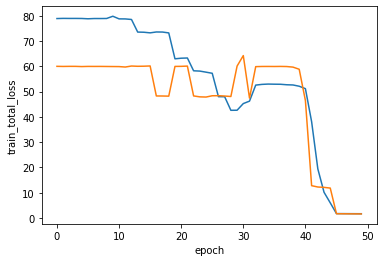

In [64]:
sns.lineplot(x = history.epoch, y = history.train_total_loss)
sns.lineplot(x = history.epoch, y = history.test_total_loss)

<AxesSubplot:xlabel='epoch', ylabel='train_bmi_loss'>

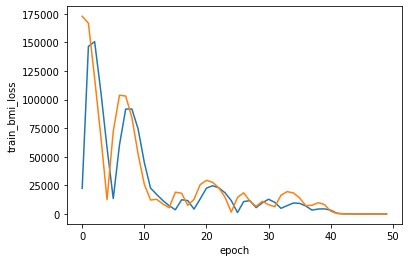

In [68]:
sns.lineplot(x = history.epoch, y = history.train_bmi_loss)
sns.lineplot(x = history.epoch, y = history.test_bmi_loss)